In [1]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from scipy.spatial import distance
import networkx as nx
import random
from scipy.ndimage import gaussian_filter, binary_dilation
from scipy.sparse.csgraph import minimum_spanning_tree
import cv2
from skimage import transform as tf
from scipy.ndimage import label, generate_binary_structure
from scipy.spatial import KDTree
import os
from skimage.morphology import skeletonize
from skimage.draw import disk

# Ici on mettre a première partie de code qui permet de pré traiter la vidéo :
Gif -> images
image0 -> grille utilisable pour le RD simulator\
Là j'ai juste mis un exemple, on part d'un grille déjà construire hors de ce dossier pour le moment

# Reaction-Diffusion Simulator

In [2]:
!./main

Generation du pattern via RD


# Traitement de la grille obtenue après génération du pattern

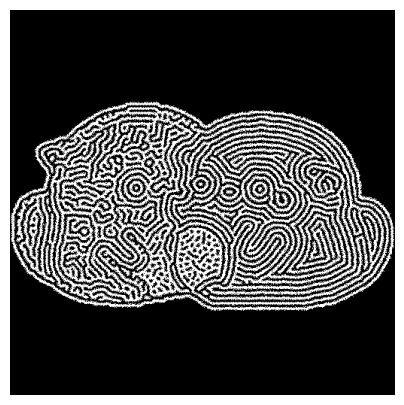

In [3]:
def load_grid(csv_path):
    return pd.read_csv(csv_path, header=None).values

def save_to_csv(grid, file_path):
    df = pd.DataFrame(grid)
    df.to_csv(file_path, header=False, index=False)

    

csv_path = 'test.csv'
grille = load_grid(csv_path)

plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(grille, cmap='gray')
plt.show()

La fonction setup fait trois choses : \
 -On lisse l'image pour éliminer les pixels qui trainent \
 -On binairise l'image pour passer à des pixels valant 0 ou 1 \
 -On transforme chaque mur en une ligne d'un pixel d'épaisseur

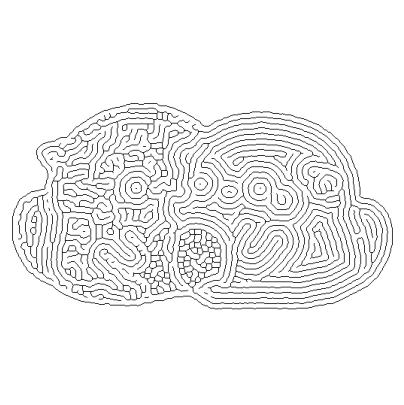

In [4]:
def setup(g):
    grille_lissée = gaussian_filter(g.astype(float), sigma=1)
    grille_binaire =(grille_lissée > 0.5).astype(int)
    grille_binaire=1-skeletonize(grille_binaire)
    return grille_binaire


grille_binaire=setup(grille)

plt.figure(figsize=(5, 5))
plt.imshow(grille_binaire, cmap='gray')
plt.axis('off')
plt.show()

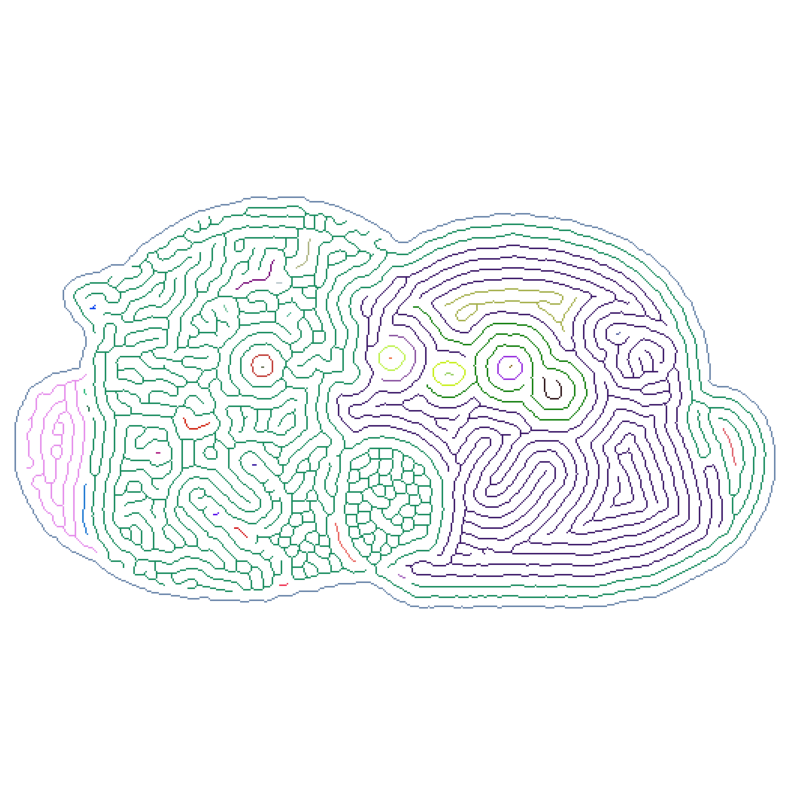

In [5]:
grid=1-grille_binaire  #on doit inverser

structure = generate_binary_structure(2, 2)  # structure de connexion 8-connexité

labeled_grid, num_features = label(grid, structure=structure) # Identifier les objets dans la grille

labeled_grid_3d = np.zeros((grid.shape[0], grid.shape[1], 3), dtype=np.uint8) # matrice 3D pour enregistrer à quelle ligne appartient chaque point


colors = {}
for i in range(1, num_features + 1):  # une couleur par ligne
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    colors[i] = color
    labeled_grid_3d[labeled_grid == i] = color


plt.figure(figsize=(10, 10))
plt.imshow(255-labeled_grid_3d)  # 255- pour afficher sur fond blanc
plt.axis('off')
plt.show()


# Déplacement des pixels

On charge l'image initiale f0, puis l'image f{i} qui correspond à la grille traitée depuis le début

In [6]:
f0 = cv2.imread('f0.png', cv2.IMREAD_GRAYSCALE)
f1 = cv2.imread('f7.png', cv2.IMREAD_GRAYSCALE)

Calcul du flux optique entre les images \
Ensuite on determine le plan de transport \
Et on remap la grille

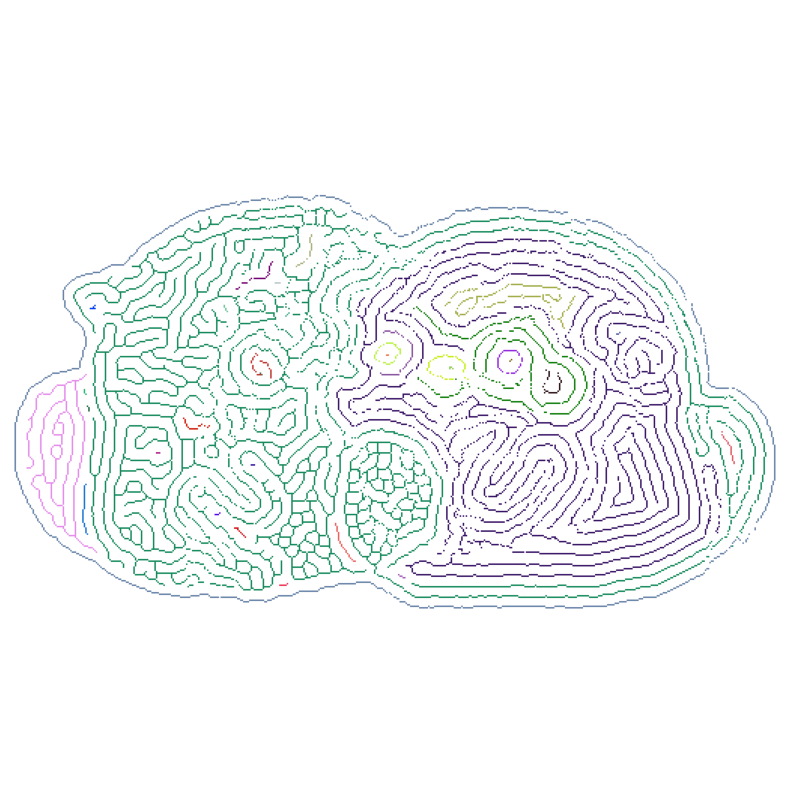

In [7]:
flow = cv2.calcOpticalFlowFarneback(f0, f1, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# Carte pour les coordonnees de destination
h, w = flow.shape[:2]
flow_map_x, flow_map_y = np.meshgrid(np.arange(w), np.arange(h))
flow_map = np.dstack((flow_map_x, flow_map_y)).astype(np.float32) + flow



moved_grid = np.zeros_like(labeled_grid_3d)

for y in range(h):
    for x in range(w):
        new_x = int(flow_map[y, x, 0])
        new_y = int(flow_map[y, x, 1])
        if 0 <= new_x < w and 0 <= new_y < h:
            moved_grid[new_y, new_x] = labeled_grid_3d[y, x]


plt.figure(figsize=(10,10))
plt.imshow(255-moved_grid)
plt.axis('off')
plt.show()

On voit que cela a brisé pas mal de lignes, normal, la transformation est, dans ce cas, injective, donc certains points de destination ne sont pas remplis.\
Il faut desormais s'assurer que les lignes soient totalement reliées !\
Là c'est plutôt pas mal, la méthode employée est vraimmmment pas opti mais pas grave

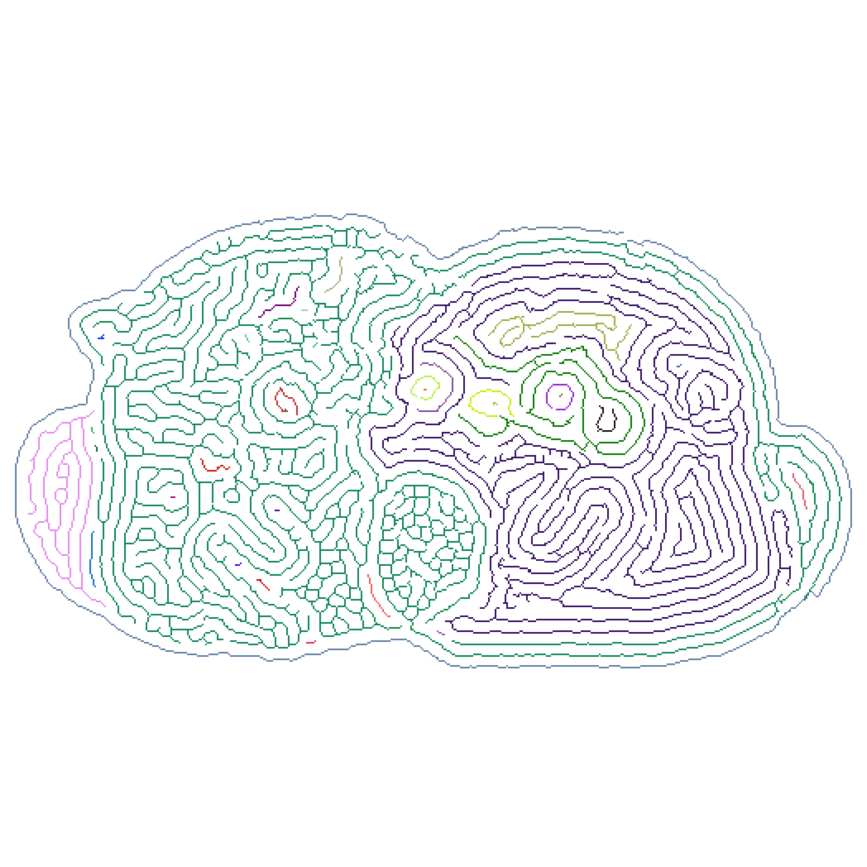

In [8]:
def connect_broken_lines(moved_grid):
    unique_colors = np.unique(moved_grid.reshape(-1, moved_grid.shape[2]), axis=0)
    unique_colors = unique_colors[np.any(unique_colors != [0, 0, 0], axis=1)]  # on vire les pixels noirs

    for color in unique_colors:
        mask = np.all(moved_grid == color, axis=-1)  # masque pour la couleur actuelle ca permet de garder juste les pixels qu'on veut
        points = np.argwhere(mask)

        if len(points) > 1:
            tree = KDTree(points)  # KDTree pour trouver les distances entre les points
            distances, indices = tree.query(points, k=len(points))

            # Créer une matrice de distances
            distance_matrix = np.zeros((len(points), len(points)))
            for i in range(len(points)):
                for j in range(1, len(points)):
                    distance_matrix[i, indices[i, j]] = distances[i, j]


            mst = minimum_spanning_tree(distance_matrix).toarray() # oui oui on passe bien par un MST, j'avais prévenu que c'était pas opti :)

            # completer les lignes de l'arbre couvrant minimal
            for i in range(len(points)):
                for j in range(len(points)):
                    if mst[i, j] > 0:
                        point1 = points[i]
                        point2 = points[j]
                        rr, cc = drawLine(point1[0], point1[1], point2[0], point2[1])
                        moved_grid[rr, cc] = color

    return moved_grid




def drawLine(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    rr, cc = zip(*points)
    return rr, cc




connected_moved_grid = connect_broken_lines(moved_grid)
# ça met quelques secondes à s'executer c'est normal


plt.figure(figsize=(11, 11))
plt.imshow(255-connected_moved_grid)
plt.axis('off')
plt.show()

Il y a quelques trous à cause de la manière avec laquelle j'ai construit l'agorithme, on s'assure que les lignes de la même couleurs ne forment qu'un seul bloc, ce qui autorise des trous à certains endroits car malgré ces trous, le graphe formé des points de la même couleur reste connexe

# Rendre le labyrinthe résoluble

La c'est ce qu'il y a dans le notebook mazeSolver.ipynb \
On traite la grille obtenue pour en faire un labyrinthe puis on peut sauvegarder l'image \
Une fois que cette partie sera bien fonctionnelle ça sera interessant de la placer AVANT le déplacement des pixels pour ne pas avoir à répeter l'étape à chaque fois.

# On transforme le tout en gif

Petit bout de code pour enregister l'image obtenu et fabriquer un gif à la fin, cette partie est à changer mais pour l'instant ça dépanne

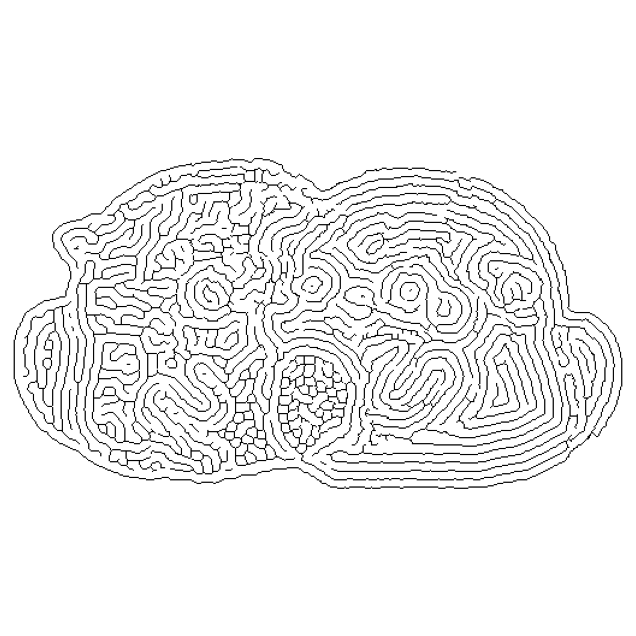

In [9]:
img = cv2.cvtColor(connected_moved_grid, cv2.COLOR_RGB2GRAY)

def generate_unique_filename(base_name, extension): #fait à l'arrache avec chatGPT, faudra programmer une boucle qui traite chaque image, puis assemble le gif. Pas dur mais à faire à la fin tranquille
    counter = 1
    while True:
        filename = f"{base_name}{counter}.{extension}"
        if not os.path.exists(filename):
            return filename
        counter += 1

unique_filename = generate_unique_filename("img", "png")

cv2.imwrite(unique_filename, img)

save_to_csv(1-(img > 0).astype(int),'remaped.csv')

plt.figure(figsize=(8,8))
plt.imshow(1-(img > 0).astype(int), cmap='gray')
plt.axis('off')
plt.show()
